In [1]:
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
import pandas

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping

Load dataset

In [2]:
data_loc = '.\\Data\\'
weights_loc = '.\\weights'

x_train19 = np.load("{}\\train_test_{}classes_testsize{}\\x_train.npy".format(data_loc,19,4))
x_test19 = np.load("{}\\train_test_{}classes_testsize{}\\x_test.npy".format(data_loc,19,4))
y_train19 = np.load("{}\\train_test_{}classes_testsize{}\\y_train.npy".format(data_loc,19,4))
y_test19 = np.load("{}\\train_test_{}classes_testsize{}\\y_test.npy".format(data_loc,19,4))

x_train20 = np.load("{}\\train_test_{}classes_testsize{}\\x_train.npy".format(data_loc,20,4))
x_test20 = np.load("{}\\train_test_{}classes_testsize{}\\x_test.npy".format(data_loc,20,4))
y_train20 = np.load("{}\\train_test_{}classes_testsize{}\\y_train.npy".format(data_loc,20,4))
y_test20 = np.load("{}\\train_test_{}classes_testsize{}\\y_test.npy".format(data_loc,20,4))

Normalize images

In [3]:
x_train19 = x_train19/255 - 0.5
x_test19 = x_test19/255 - 0.5

x_train20 = x_train20/255 - 0.5
x_test20 = x_test20/255 - 0.5

One-hot encode labels

In [4]:
y_train_dummies19 = pandas.get_dummies(y_train19)
y_train_dummies19 = y_train_dummies19.values
y_test_dummies19 = pandas.get_dummies(y_test19)
y_test_dummies19 = y_test_dummies19.values

y_train_dummies20 = pandas.get_dummies(y_train20)
y_train_dummies20 = y_train_dummies20.values
y_test_dummies20 = pandas.get_dummies(y_test20)
y_test_dummies20 = y_test_dummies20.values

Build CNN architecture

In [5]:
def create_model(no_of_classes):
    model = Sequential()
    model.add(Conv2D(input_shape=(224,224,3),filters=32,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
    model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=1024,activation="relu"))
    model.add(Dense(units=no_of_classes, activation="softmax"))

    return model

# 19 categories

Train & choose best model for 19 categories

In [6]:
no_of_classes = 19
train_accs, test_accs, w = [],[],[]
w19 = []

# # Train multiple models with different initialized weights and keep the model with best test accuracy
for i in range(30):
    model = create_model(no_of_classes)
    opt = Adam(lr=0.001)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    #model.summary()
    history = model.fit(x_train19, y_train_dummies19, batch_size = 64, epochs = 100, validation_data = (x_test19,y_test_dummies19), verbose = 1, callbacks=[es])

    # Evaluate model
    train_acc = model.evaluate(x_train19, y_train_dummies19, verbose=1)[1]
    test_acc = model.evaluate(x_test19, y_test_dummies19, verbose=1)[1]
    print('Iteration: {} Train: {}, Test: {}'.format(i, train_acc, test_acc))
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    w19.append(model.get_weights())

Save best model for 19 categories

In [7]:
print('Test accuracies: {}, best: {}'.format(test_accs,np.max(test_accs))) 
best_run = np.argmax(test_accs)
np.save("{}\\weights_CNN_19.npy".format(weights_loc),w19[best_run])

Load best model and check predictions on test set

In [8]:
w19 = np.load("{}\\weights_CNN_19.npy".format(weights_loc),allow_pickle=True)
model_19 = create_model(19)
model_19.set_weights(w19)

In [9]:
# Evaluate model on all data
opt = Adam(learning_rate=0.001)
model_19.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
train_acc = model_19.evaluate(x_train19, y_train_dummies19, verbose=1)[1]
test_acc = model_19.evaluate(x_test19, y_test_dummies19, verbose=1)[1]
print('\n Train: {}, Test: {}'.format(train_acc, np.round(test_acc,2)))

3/3 [==============================] - 1s 231ms/step - loss: 0.3303 - accuracy: 0.9605

 Train: 1.0, Test: 0.96


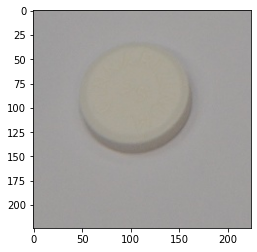

In [10]:
# Evaluate model on image below
im = x_test19[5]
plt.imshow(((im+0.5)*255).astype(int))

In [11]:
class_order = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:10,9:11,10:12,11:13,12:14,13:15,14:16,15:17,16:18,17:19,18:20}
pred = model_19.predict(im.reshape(1,224,224,3))
arg_max = np.argmax(pred)
label = class_order[arg_max]
print("Predicted label: {}".format(label),'\n')
print("Confidence: {} %".format(np.round(pred[0][arg_max] * 100,2)))

Predicted label: 15 

Confidence: 99.57 %


In [12]:
print("True label: {}".format(y_test19[5]))

True label: 15


# 20 categories

Re-train Dense layers for 20 categories

In [13]:
no_of_classes = 20
train_accs, test_accs, w = [],[],[]
w20 = []

# # Train multiple models with different initialized weights and keep the model with best test accuracy
for i in range(10):
    model = create_model(no_of_classes)
    # All convolutional layers take the parameters already trained for 19 categories
    for layer in range(6):
        model.weights[layer] = w19[layer]

    opt = Adam(lr=0.001)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    model.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    #model.summary()
    history = model.fit(x_train20, y_train_dummies20, batch_size = 64, epochs = 100, validation_data = (x_test20,y_test_dummies20), verbose = 1, callbacks=[es])

    # Evaluate model
    train_acc = model.evaluate(x_train20, y_train_dummies20, verbose=1)[1]
    test_acc = model.evaluate(x_test20, y_test_dummies20, verbose=1)[1]
    print('Iteration: {} Train: {}, Test: {}'.format(i, train_acc, test_acc))
    train_accs.append(train_acc)
    test_accs.append(test_acc)
    w20.append(model.get_weights())


In [14]:
print('Test accuracies: {}, best: {}'.format(test_accs,np.max(test_accs))) 
best_run = np.argmax(test_accs)
np.save("{}\\weights_CNN_20.npy".format(weights_loc),w20[best_run])

Load best model and check predictions on test set

In [15]:
w20 = np.load("{}\\weights_CNN_20.npy".format(weights_loc),allow_pickle=True)
model_20 = create_model(20)
model_20.set_weights(w20)

In [16]:
# Evaluate model on all data
opt = Adam(learning_rate=0.001)
model_20.compile(optimizer=opt, loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
train_acc = model_20.evaluate(x_train20, y_train_dummies20, verbose=1)[1]
test_acc = model_20.evaluate(x_test20, y_test_dummies20, verbose=1)[1]
print('\n Train: {}, Test: {}'.format(train_acc, np.round(test_acc,2)))

3/3 [==============================] - 2s 220ms/step - loss: 0.3987 - accuracy: 0.9625

 Train: 1.0, Test: 0.96


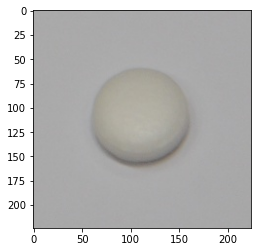

In [17]:
# Evaluate model on image below
im = x_test20[0]
plt.imshow(((im+0.5)*255).astype(int))

In [18]:
class_order = {0:1,1:2,2:3,3:4,4:5,5:6,6:7,7:8,8:9,9:10,10:11,11:12,12:13,13:14,14:15,15:16,16:17,17:18,18:19,19:20}
pred = model_20.predict(im.reshape(1,224,224,3))
arg_max = np.argmax(pred)
label = arg_max + 1
print("Predicted label: {}".format(label),'\n')
print("Confidence: {} %".format(np.round(pred[0][arg_max] * 100,2)))

Predicted label: 5 

Confidence: 99.43 %


In [19]:
print("True label: {}".format(y_test20[0]))

True label: 5
